In [2]:
date()

[1] "Mon Jan 09 16:59:25 2017"

In [3]:
sapply(c("pipeR", "dplyr", "tidyr", "purrr", "ggplot2", "readr"), require, character.only= TRUE)

Loading required package: pipeR
Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: tidyr
Loading required package: purrr

Attaching package: 'purrr'

The following objects are masked from 'package:dplyr':

    contains, order_by

Loading required package: ggplot2
Loading required package: readr


pipeR   dplyr   tidyr   purrr ggplot2   readr 
   TRUE    TRUE    TRUE    TRUE    TRUE    TRUE

# 11章 空間構造のある階層ベイズモデル

空間相関

* 個体差は独立ではない
* 空間上の配置の影響を受ける
* 近いところとは似ていて，離れると似ていない

## 11.1 例題: 一次元空間上の個体数分布

* 調査区画: 50個
* とある植物の区画ごとの個体数を数えた
* **局所密度** に類似性がある

In [4]:
load("data/chap11/Y.RData")
ls.str()

m :  Named num [1:50] 2.15 3.25 4.63 6.23 7.99 ...
Y :  num [1:50] 0 3 2 5 6 16 8 14 11 10 ...

In [5]:
options(repr.plot.width = 4,repr.plot.height = 3)

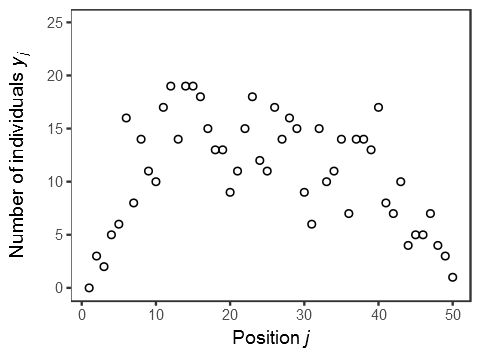

In [28]:
# Fig. 11.2
data_frame(j = seq_along(Y), y = Y) %>>% 
    ggplot(aes(x = j, y = y)) + 
    geom_point(shape = 21)+ 
    theme_bw() +
    theme(panel.grid = element_blank()) + 
    xlab(expression("Position "*italic("j"))) + 
    ylab(expression("Number of individuals  "*italic("y")[italic("j")])) + 
    ylim(c(0, 25))

## 11.2 階層ベイズモデルに空間構造をくみこむ

個体数 $y_j$ がすべての区画で共通の平均値 $\lambda$ のポアソン分布に従うとする．

$$ p(y_j \mid \lambda) = \frac{\lambda^{y_j}\exp(-\lambda)}{y_j!} $$

標本平均は，

In [37]:
mean(Y)

[1] 10.88

10.9 ぐらいなので，分散も同じぐらいになるはずだが，標本分散は，

In [38]:
var(Y)

[1] 27.37306

27.4 ぐらいなので，過分散が生じている．

図 11.2 を見ると，個体数 $y_j$ は位置によって変化しているように見える．

区画ごとに異なる $\lambda_j$ をもつとする．
平均個体数 $\lambda_j$ を線形予測子と対数リンク関数を用いて，以下のようにあらわす．

$$\log \lambda_j =\beta + r_j$$

ここで，

* $\beta$ は切片で大域的なパラメータ => 無情報事前分布
* $r_j$ は場所差で局所的なパラメータ => 階層事前分布

### 11.2.1 空間構造のない階層事前分布

場所差 $r_j$ の階層事前分布

* 10章のようにすると，$r_j$ はどれも独立になる
    * 平均0，標準偏差s の正規分布

$$ p(r_j \mid s) = \frac{1}{\sqrt{2 \pi s^2}} \exp \left( -\frac{r_j^2}{2s^2} \right) $$

* 

### 11.2.2 空間構造のある階層事前分布

場所差$r_j$に制約を設ける

1. 場所差は「近傍」区画の場所差にしか影響されない
1. 区画$j$の近傍の個数 $n_j$ は有限個であり，どの区画が近傍であるかはあらかじめ設定する
1. 近傍の直接の影響はどれも等しく，$1 / n_j$

簡単のために，近傍数は2とする

* 両隣の影響しか受けない
* 両端については近傍数1

$r_j$ の事前分布を以下のように設定する

$$ p(r_j \mid \mu_j, s) = \sqrt{\frac{n_j}{2 \pi s^2}} \exp \left\{ -\frac{(r_j - \mu_j)^2}{2s^2 / n_j} \right\} $$

ここで，平均 
$\mu_j$ は近傍の平均値に等しいとする

$$ \mu_j = \frac{r_{j-1} + r_{j+1}}{2} $$

* 両端では，$\mu_1 = r_2$，$\mu_{50} = r_49$
* 標準偏差は $s / \sqrt{n_j}$
* $s$ はどこでも等しい 

条件つき自己回帰（Conditional Auto Regressive, CAR）モデル

のなかでも

**intristic Gaussian CAR** モデルという

場所差 $\{ r_j \} = \{ r_1, r_2, \ldots, r_{50}\}$ 全体の事前分布である同時分布は，以下のように書ける

* $j \sim j^\prime$ は$j$と $j^\prime$ が近傍であるようなすべての $\{j, j^\prime\}$ の組み合わせ

$$ p( \{r_j \} \mid s) \propto \exp \left\{ -\frac{1}{2s^2} \sum\limits_{j \sim j^\prime} (r_j - r_{j^\prime})^2 \right\} $$

この同時分布において，$r_j$を除くすべての$\{ r_* \}$ を定数とおくと，条件つき事前分布 $p(r_j \mid \mu_j, s)$ が得られる（Full Conditional 形式）．

## 11.3 空間統計モデルをデータにあてはめる

事前分布は，

$$ p(\beta, s, \{ r_j \} \mid \boldsymbol{Y}) \propto p(\{ r_j \} \mid s) p(s) p(\beta) \prod\limits_j p(y_j \mid \lambda_j) $$

* データ $y_j$ が得られる確率: 平均 $\lambda_j = \exp (\beta + r_j)$ のポアソン分布
    * $\beta$の事前分布: 無情報事前分布（$p(\beta)$）
    * $r_j$ の事前分布: 空間構造を考慮した階層事前分布（同時分布$p(\{ r_j \} \mid s)$）
* 個々の$r_j$ の条件付事前分布: 平均 $\mu_j$，標準偏差 $s/\sqrt{n_j}$の正規分布 $p(r_j \mid \mu_j, s)$
    * $s$ の事前分布: 無情報事前分布（$p(s)$）

### WinBUGS を使う場合

* `car.normal()` を使うと，Intristic Gaussian CAR モデルを扱える

In [41]:
readLines("chap11-model.jags", encoding = "UTF-8") %>>% cat(sep = "\n")

model
{
  for (j in 1:N.site) {
    Y[j] ~ dpois(mean[j]) # ポアソン分布
    log(mean[j]) <- beta + r[j] # （切片） + （場所差）
  }
  # 場所差 r[j] をCAR model で生成
  # car.normal()
  ## Adj[]: 隣接する場所の番号
  ## Weights[]: Adj[] に対応する重み
  ## Num[]: 隣接数 n_j
  ## tau: 分散の逆数
  r[1:N.site] ~ car.normal(Adj[], Weights[], Num[], tau)
  beta ~ dnorm(0, 1.0E-4)
  tau <- 1 / (s * s) # tau は分散の逆数
  s ~ dunif(0, 1.0E+4)
}



### JAGS を使う場合

`car.normal()` はないので，別の表現に置き換える．

時間・空間を含むベイズモデルは，いくつかの形式で表現できる

（詳しくは

> * 『岩波データサイエンス Vol.1』
> * https://www.youtube.com/watch?v=M7rN6paP99g
> * http://rion778.hatenablog.com/entry/2016/10/08/220358
> * http://statmodeling.hatenablog.com/entry/markov-field-model
> * http://ito-hi.blog.so-net.ne.jp/2015-02-15
> * http://ito-hi.blog.so-net.ne.jp/2015-02-16
> * 『StanとRでベイズ統計モデリング』

などを参照．以降の説明は 『岩波データサイエンス Vol.1』 より）

岩波データサイエンス Vol.1 では以下の4つが紹介されている．

1. 状態空間モデル
1. 条件つき分布
1. マルコフ場モデル
1. Full Conditional

今回の

$$ p(r_j \mid r_{-j}) = \sqrt{\frac{n_j}{2 \pi s^2}} \exp \left\{-\frac{n_j}{2s^2}\left[ r_j - \frac{1}{2}(r_{j-1} + r_{j+1}) \right] \right\} $$

は，各変数についてそれ以外のすべての変数を固定した条件つき分布であり，（4）Full Conditional な形式である

これは，p.248の注釈9にある通り，有向非巡回グラフ（Directed acyclic graph，DAG）ではないので，JAGS で表現できない．

Intristic CAR モデル は状態空間モデル の形式で表現することができるので，こちらの形式のものをJAGSで表現することを考える．

#### 状態空間モデル

ある隠れた状態 $\{ x_i\} = \{x_1, x_2, \ldots, x_i \}$ から データ $\{ y_i\} = \{y_1, y_2, \ldots, y_i \}$ が観測されるとする．

$x_i$ に システム雑音 $\eta_i$ が加わって $x_{i+1}$ に遷移し，$x_i$ から $y_i$ を観測する際には，観測雑音 $\epsilon_i$ が加わるとすると，

$$
\begin{align}
x_{i+1} &= x_i + \eta_i \\ 
y_i &=  x_i + \epsilon_i
\end{align}
$$

となる．



#### 条件つき分布

（1）の状態空間モデルの形式を，
状態間の移動をあらわす条件つき密度 $p(x_{i+1} \mid x_i )$ と
測定のときの誤差をあらわす条件つき密度 $p(y_i \mid x_i)$
で表現する．

$$
\begin{align}
\eta_i &= x_{i+1} - x_i \\ 
\epsilon_i &= y_i - x_i
\end{align}
$$

なので，

$$ p(x_{i+1} \mid x_i ) = \frac{1}{\sqrt{2 \pi s^2}} \exp \left( -\frac{1}{2 s^2} (x_{i+1} - x_i)^2 \right)$$
$$ p(y_i \mid x_i) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( -\frac{1}{2 \sigma^2} (y_{i} - x_i)^2 \right) $$

また，初期値 $x_1$ の事前密度 $p(x_1)$を，平均0，分散$r^2$の正規分布とし，$s^2$，$\sigma^2$の事前密度を $p(s^2)$，$p(\sigma^2)$ とすると，ベイズモデルを定義する同時密度は，次のようになる．

$$ p(\{y_i\}, \{x_i\}, s^2, \sigma^2) = p(s^2) p(\sigma^2)p(x_1) \prod\limits^{N}_{i=1}p(y_i \mid x_i)  \prod\limits^{N-1}_{i=1}p(x_{i+1} \mid x_i) $$

#### 今回の例題だと

* 観測値 $y$ は平均$\lambda$のポアソン分布に従う
    * $\lambda$ の対数が 状態 $r$ になる
* 状態 $r$ は標準偏差 $s$ の正規分布にしたがってランダムウォークする

In [13]:
readLines("chap11-model2.jags", encoding = "UTF-8") %>>% cat(sep = "\n")

model {
  for (j in 1:N.site){
    Y[j] ~ dpois(lambda[j])
    lambda[j] <- exp(r[j])
  }
  for (j in 2:N.site){
    r[j] ~ dnorm(r[j - 1], tau)
  }
  r[1] ~ dunif(0, 10)
  tau <- 1 / (s * s)
  s ~ dunif(0, 1.0E+4)
}


<img src="images/chap11/fig1.png" width = 800></img>

In [7]:
library(rjags)

Loading required package: coda
Linked to JAGS 4.2.0
Loaded modules: basemod,bugs


In [9]:
data.list2 <- list(
    N.site = length(Y), 
    Y = Y
)

In [10]:
data.list2

$N.site
[1] 50

$Y
 [1]  0  3  2  5  6 16  8 14 11 10 17 19 14 19 19 18 15 13 13  9 11 15 18 12 11
[26] 17 14 16 15  9  6 15 10 11 14  7 14 14 13 17  8  7 10  4  5  5  7  4  3  1

In [14]:
m2 <- jags.model(
    file = "chap11-model2.jags", 
    data = data.list,
    n.chain = 3, 
    n.adapt = 100
)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 50
   Unobserved stochastic nodes: 51
   Total graph size: 159

Initializing model



In [17]:
post.jags2 <- coda.samples(m, variable.names = c("r", "s"), n.iter = 10000, thin = 10)

In [18]:
saveRDS(post.jags2, file = "chap11-post-jags2.rds")

In [ ]:
post.jags2 <- readRDS(file = "chap11-post-jags2.rds")

In [19]:
summary(post.jags2)


Iterations = 110:10100
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean       SD Naive SE Time-series SE
r[1]   1.042   0.3678 0.006716       0.008567
r[2]   1.190   0.3141 0.005735       0.006963
r[3]   1.360   0.2878 0.005255       0.006663
r[4]   1.646   0.2374 0.004335       0.004539
r[5]   1.934   0.2144 0.003915       0.004059
r[6]   2.287   0.2036 0.003717       0.004316
r[7]   2.299   0.1860 0.003397       0.003398
r[8]   2.443   0.1848 0.003374       0.003581
r[9]   2.455   0.1813 0.003309       0.003389
r[10]  2.505   0.1763 0.003219       0.003280
r[11]  2.701   0.1675 0.003059       0.002985
r[12]  2.798   0.1642 0.002998       0.003046
r[13]  2.766   0.1610 0.002939       0.002964
r[14]  2.850   0.1592 0.002907       0.002908
r[15]  2.869   0.1570 0.002866       0.003029
r[16]  2.814   0.1585 0.002893       0.003120
r[17]  2.705   0.164

In [20]:
gelman.diag(post.jags2)

Potential scale reduction factors:

      Point est. Upper C.I.
r[1]       1.000      1.001
r[2]       1.001      1.003
r[3]       0.999      1.000
r[4]       1.001      1.006
r[5]       1.000      1.002
r[6]       0.999      1.000
r[7]       1.000      1.001
r[8]       1.001      1.006
r[9]       1.000      1.000
r[10]      1.003      1.007
r[11]      1.003      1.003
r[12]      1.000      1.000
r[13]      1.007      1.017
r[14]      1.001      1.005
r[15]      1.003      1.014
r[16]      1.001      1.006
r[17]      1.001      1.006
r[18]      1.000      1.002
r[19]      1.004      1.016
r[20]      1.007      1.029
r[21]      1.001      1.006
r[22]      1.002      1.010
r[23]      1.000      1.003
r[24]      0.999      1.000
r[25]      1.002      1.008
r[26]      1.001      1.003
r[27]      1.001      1.007
r[28]      1.001      1.002
r[29]      1.000      1.003
r[30]      1.001      1.004
r[31]      1.000      1.001
r[32]      1.003      1.011
r[33]      1.004      1.016
r[34]      0

In [22]:
varnames(post.jags2)

[1] "r[1]"  "r[2]"  "r[3]"  "r[4]"  "r[5]"  "r[6]"  "r[7]"  "r[8]"  "r[9]" 
[10] "r[10]" "r[11]" "r[12]" "r[13]" "r[14]" "r[15]" "r[16]" "r[17]" "r[18]"
[19] "r[19]" "r[20]" "r[21]" "r[22]" "r[23]" "r[24]" "r[25]" "r[26]" "r[27]"
[28] "r[28]" "r[29]" "r[30]" "r[31]" "r[32]" "r[33]" "r[34]" "r[35]" "r[36]"
[37] "r[37]" "r[38]" "r[39]" "r[40]" "r[41]" "r[42]" "r[43]" "r[44]" "r[45]"
[46] "r[46]" "r[47]" "r[48]" "r[49]" "r[50]" "s"

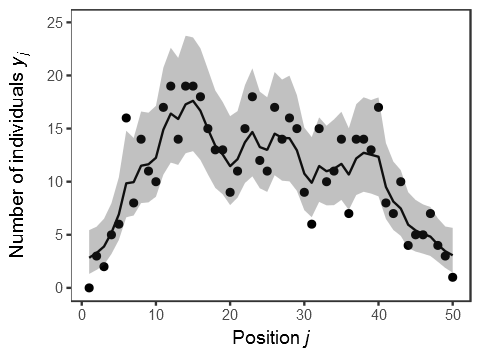

In [27]:
Y.hat <- exp(summary(post.jags2[, grep("r", varnames(post.jags2))])$statistics[, "Mean"])
Y.qnt <- exp(summary(post.jags2[, grep("r", varnames(post.jags2))])$quantiles[, c("2.5%", "97.5%")])

data_frame(site = seq_along(Y), 
           Y = Y,
           Y.hat = Y.hat,
           Y.975 = Y.qnt[, 2],
           Y.025 = Y.qnt[, 1]) %>>% 
    ggplot() +
        geom_point(aes(x = site, y = Y)) +
        geom_line(aes(x = site, y = Y.hat)) +
        geom_ribbon(aes(x = site, ymin = Y.025, ymax = Y.975), alpha = 0.3) + 
        theme_bw() + 
        theme(
            panel.grid = element_blank()
        ) + 
        xlab(expression("Position "*italic("j"))) + 
        ylab(expression("Number of individuals  "*italic("y")[italic("j")])) + 
        ylim(c(0, 25))

## 11.4 空間統計モデルが作り出す確率場

隣と似ている度合いが変わるとどうなるか

In [34]:
data.list3 <- list(
    N.site = length(Y), 
    Y = matrix(c(Y, Y, Y), length(Y), 3), 
    Tau = c(1000, 20, 0.01)
)

In [77]:
m3 <- jags.model(
    file = "chap11-model3.jags", 
    data = data.list3,
    n.chain = 3, 
    n.adapt = 100
)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 150
   Unobserved stochastic nodes: 150
   Total graph size: 460

Initializing model



In [78]:
post.jags3 <- coda.samples(m3, variable.names = c("r"), n.iter = 200, thin = 1)

In [161]:
saveRDS(post.jags3, file = "chap11-post-jags3.rds")

In [ ]:
post.jags3 <- readRDS("chap11-post-jags3.rds")

In [79]:
summary(post.jags3)


Iterations = 101:300
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 200 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

           Mean      SD Naive SE Time-series SE
r[1,1]   2.4691 0.13102 0.005349       0.038806
r[2,1]   2.4788 0.12626 0.005155       0.041268
r[3,1]   2.4943 0.11987 0.004894       0.039448
r[4,1]   2.5170 0.11655 0.004758       0.033268
r[5,1]   2.5468 0.11249 0.004592       0.033282
r[6,1]   2.5777 0.10926 0.004460       0.031284
r[7,1]   2.6012 0.10783 0.004402       0.028907
r[8,1]   2.6275 0.10954 0.004472       0.029622
r[9,1]   2.6485 0.11243 0.004590       0.029293
r[10,1]  2.6708 0.11140 0.004548       0.031918
r[11,1]  2.6979 0.10777 0.004400       0.034170
r[12,1]  2.7200 0.10450 0.004266       0.029612
r[13,1]  2.7375 0.09975 0.004072       0.032445
r[14,1]  2.7545 0.09858 0.004024       0.029005
r[15,1]  2.7630 0.09956 0.004065       0.030960
r[16,1]  2.7647 0.10037 0.004097      

In [80]:
str(post.jags3)

List of 3
 $ : mcmc [1:200, 1:150] 2.58 2.55 2.51 2.54 2.53 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:150] "r[1,1]" "r[2,1]" "r[3,1]" "r[4,1]" ...
  ..- attr(*, "mcpar")= num [1:3] 101 300 1
 $ : mcmc [1:200, 1:150] 2.74 2.85 2.85 2.82 2.83 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:150] "r[1,1]" "r[2,1]" "r[3,1]" "r[4,1]" ...
  ..- attr(*, "mcpar")= num [1:3] 101 300 1
 $ : mcmc [1:200, 1:150] 2.6 2.61 2.66 2.67 2.68 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:150] "r[1,1]" "r[2,1]" "r[3,1]" "r[4,1]" ...
  ..- attr(*, "mcpar")= num [1:3] 101 300 1
 - attr(*, "class")= chr "mcmc.list"


* s = 0.0316

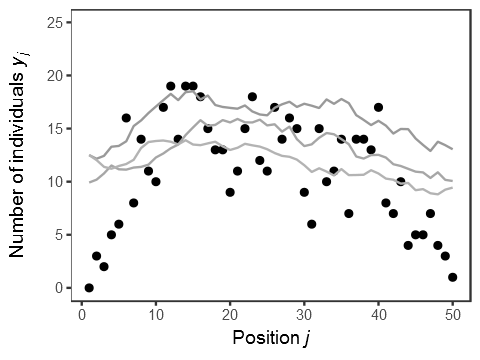

In [156]:
post.jags3 %>>% purrr::map_df(function(x){as_data_frame(x)}) %>>% dplyr::sample_n(3) %>>% 
    select(ends_with("1]")) %>>% t() %>>% as_data_frame() %>>% 
    purrr::dmap(function(x){exp(x)}) %>>% 
    mutate(site = seq_along(Y), Y = Y) %>>% 
    ggplot() + 
        geom_point(aes(x = site, y = Y)) + 
        geom_line(aes(x = site, y = V1), colour = gray(0.6)) + 
        geom_line(aes(x = site, y = V2), colour = gray(0.65)) + 
        geom_line(aes(x = site, y = V3), colour = gray(0.7)) + 
        theme_bw() + theme(panel.grid = element_blank()) + 
        xlab(expression("Position "*italic("j"))) + 
        ylab(expression("Number of individuals  "*italic("y")[italic("j")])) + 
        ylim(c(0, 25))

* s = 0.224

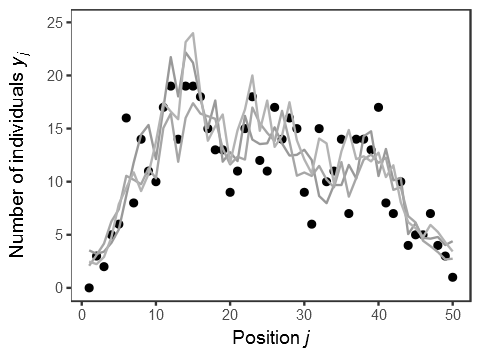

In [157]:
post.jags3 %>>% purrr::map_df(function(x){as_data_frame(x)}) %>>% dplyr::sample_n(3) %>>% 
    select(ends_with("2]")) %>>% t() %>>% as_data_frame() %>>% 
    purrr::dmap(function(x){exp(x)}) %>>% 
    mutate(site = seq_along(Y), Y = Y) %>>% 
    ggplot() + 
        geom_point(aes(x = site, y = Y)) + 
        geom_line(aes(x = site, y = V1), colour = gray(0.6)) + 
        geom_line(aes(x = site, y = V2), colour = gray(0.65)) + 
        geom_line(aes(x = site, y = V3), colour = gray(0.7)) + 
        theme_bw() + theme(panel.grid = element_blank()) + 
        xlab(expression("Position "*italic("j"))) + 
        ylab(expression("Number of individuals  "*italic("y")[italic("j")])) + 
        ylim(c(0, 25))

* s = 10.0

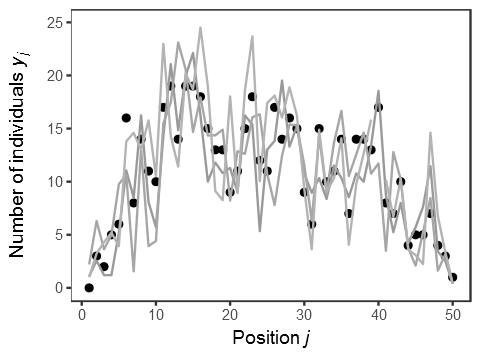

In [158]:
post.jags3 %>>% purrr::map_df(function(x){as_data_frame(x)}) %>>% dplyr::sample_n(3) %>>% 
    select(ends_with("3]")) %>>% t() %>>% as_data_frame() %>>% 
    purrr::dmap(function(x){exp(x)}) %>>% 
    mutate(site = seq_along(Y), Y = Y) %>>% 
    ggplot() + 
        geom_point(aes(x = site, y = Y)) + 
        geom_line(aes(x = site, y = V1), colour = gray(0.6)) + 
        geom_line(aes(x = site, y = V2), colour = gray(0.65)) + 
        geom_line(aes(x = site, y = V3), colour = gray(0.7)) + 
        theme_bw() + theme(panel.grid = element_blank()) + 
        xlab(expression("Position "*italic("j"))) + 
        ylab(expression("Number of individuals  "*italic("y")[italic("j")])) + 
        ylim(c(0, 25))

## 11.5 空間相関モデルと欠測のあるデータ

状態空間モデルの場合は，モデルを少し書き換える必要がある
（どこが欠測かを明示する必要がある）

空間相関あり

In [183]:
Idx.obs <- c(1:50)[-c(6, 9, 12, 13, 26:30)]
Y.obs <- Y[Idx.obs]
data.list4 <- list(
    N.site = length(Y), 
    Idx.obs = Idx.obs, 
    Y.obs = Y.obs, 
    N.obs = length(Y.obs)
)

In [184]:
m4 <- jags.model(
    file = "chap11-model4.jags", 
    data = data.list4,
    n.chain = 3, 
    n.adapt = 100
)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 41
   Unobserved stochastic nodes: 51
   Total graph size: 183

Initializing model



In [185]:
post.jags4 <- coda.samples(
    m2, 
    c("r", "s"), 
    n.iter = 10000, 
    thin = 10
)

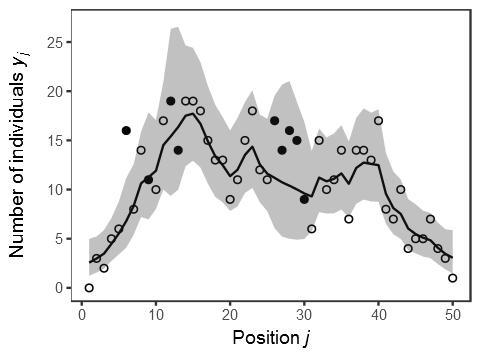

In [194]:
(function(){
    Y.hat <- exp(summary(post.jags4[, grep("r", varnames(post.jags4))])$statistics[, "Mean"])
    Y.qnt <- exp(summary(post.jags4[, grep("r", varnames(post.jags4))])$quantiles[, c("2.5%", "97.5%")])
    p.fill <- rep("black", 50)
    p.fill[Idx.obs] <- "white"
    data_frame(site = seq_along(Y), 
           Y = Y,
           Y.hat = Y.hat,
           Y.975 = Y.qnt[, 2],
           Y.025 = Y.qnt[, 1]) %>>% 
    ggplot() +
        geom_point(aes(x = site, y = Y), shape = 21, fill = p.fill) +
        geom_line(aes(x = site, y = Y.hat)) +
        geom_ribbon(aes(x = site, ymin = Y.025, ymax = Y.975), alpha = 0.3) + 
        theme_bw() + 
        theme(
            panel.grid = element_blank()
        ) + 
        xlab(expression("Position "*italic("j"))) + 
        ylab(expression("Number of individuals  "*italic("y")[italic("j")])) + 
        scale_y_continuous(breaks = seq(0, 25, 5), limits = c(0, 27))
})()

空間相関なし

In [226]:
m5 <- jags.model(
    file = "chap11-model5.jags", 
    data = data.list4,
    n.chain = 3, 
    n.adapt = 100
)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 41
   Unobserved stochastic nodes: 52
   Total graph size: 275

Initializing model



In [227]:
post.jags5 <- coda.samples(
    m5, 
    c("r", "beta", "s"), 
    n.iter = 10000,
    thin = 10
)

In [228]:
gelman.diag(post.jags5)

Potential scale reduction factors:

      Point est. Upper C.I.
beta       1.004      1.015
r[1]       1.000      1.000
r[2]       1.002      1.003
r[3]       1.001      1.002
r[4]       1.001      1.002
r[5]       1.001      1.006
r[6]       0.999      0.999
r[7]       1.002      1.002
r[8]       1.010      1.038
r[9]       1.000      1.003
r[10]      1.001      1.005
r[11]      1.002      1.007
r[12]      1.001      1.007
r[13]      1.001      1.006
r[14]      1.000      1.000
r[15]      1.001      1.003
r[16]      1.003      1.009
r[17]      1.000      1.001
r[18]      1.000      1.000
r[19]      1.001      1.003
r[20]      1.000      1.001
r[21]      1.001      1.004
r[22]      1.007      1.024
r[23]      1.002      1.007
r[24]      1.001      1.003
r[25]      1.001      1.005
r[26]      0.999      0.999
r[27]      1.000      1.001
r[28]      1.001      1.004
r[29]      1.001      1.004
r[30]      0.999      1.000
r[31]      1.001      1.003
r[32]      1.005      1.021
r[33]      1

In [225]:
summary(post.jags5)


Iterations = 10110:20100
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

           Mean      SD Naive SE Time-series SE
beta   2.194261 0.09978 0.001822       0.002274
r[1]  -0.945356 0.41808 0.007633       0.007798
r[2]  -0.578535 0.35221 0.006431       0.006430
r[3]  -0.699867 0.37076 0.006769       0.006445
r[4]  -0.371389 0.32156 0.005871       0.005780
r[5]  -0.271246 0.30845 0.005631       0.005632
r[6]   0.009398 0.53501 0.009768       0.009487
r[7]  -0.106109 0.29469 0.005380       0.005295
r[8]   0.317402 0.26937 0.004918       0.004920
r[9]   0.021335 0.52676 0.009617       0.009620
r[10]  0.051228 0.28460 0.005196       0.005195
r[11]  0.480604 0.24998 0.004564       0.004953
r[12]  0.013790 0.52775 0.009635       0.009633
r[13] -0.007827 0.52739 0.009629       0.009505
r[14]  0.584996 0.24027 0.004387       0.004624
r[15]  0.584400 0.24815 0.004531

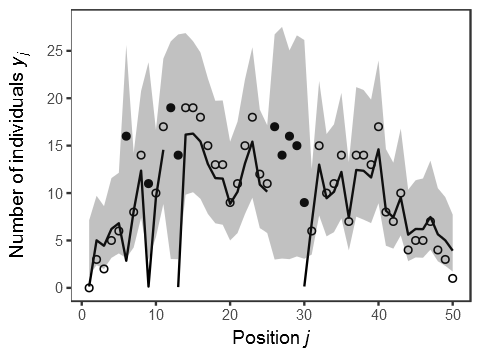

In [239]:
(function(){
    beta <- summary(post.jags5[, "beta"])$statistics[["Mean"]]
    Y.hat <- exp(beta + summary(post.jags5[, grep("r", varnames(post.jags5))])$statistics[, "Mean"])
    Y.qnt <- exp(beta + summary(post.jags5[, grep("r", varnames(post.jags5))])$quantiles[, c("2.5%", "97.5%")])
    p.fill <- rep("black", 50)
    p.fill[Idx.obs] <- "white"
    data_frame(site = seq_along(Y), 
           Y = Y,
           Y.hat = Y.hat,
           Y.975 = Y.qnt[, 2],
           Y.025 = Y.qnt[, 1]) %>>% 
    ggplot() +
        geom_point(aes(x = site, y = Y), shape = 21, fill = p.fill) +
        geom_line(aes(x = site, y = Y.hat)) +
        geom_ribbon(aes(x = site, ymin = Y.025, ymax = Y.975), alpha = 0.3) + 
        theme_bw() + 
        theme(
            panel.grid = element_blank()
        ) + 
        xlab(expression("Position "*italic("j"))) + 
        ylab(expression("Number of individuals  "*italic("y")[italic("j")])) + 
        scale_y_continuous(breaks = seq(0, 25, 5), limits = c(0, 28))
})()

すこしおかしい気がする

## 11.6 まとめ

In [29]:
devtools::session_info()

Session info -------------------------------------------------------------------
Packages -----------------------------------------------------------------------


 setting  value                       
 version  R version 3.3.2 (2016-10-31)
 system   x86_64, mingw32             
 ui       RTerm                       
 language (EN)                        
 collate  Japanese_Japan.932          
 tz       Asia/Tokyo                  
 date     2017-01-09                  

 package    * version date       source                            
 assertthat   0.1     2013-12-06 CRAN (R 3.2.1)                    
 Cairo        1.5-9   2015-09-26 CRAN (R 3.2.2)                    
 coda       * 0.18-1  2015-10-16 CRAN (R 3.2.3)                    
 colorspace   1.2-7   2016-10-11 CRAN (R 3.3.2)                    
 crayon       1.3.2   2016-06-28 CRAN (R 3.3.1)                    
 DBI          0.5-1   2016-09-10 CRAN (R 3.2.5)                    
 devtools     1.12.0  2016-06-24 CRAN (R 3.3.1)                    
 digest       0.6.10  2016-08-02 CRAN (R 3.3.1)                    
 dplyr      * 0.5.0   2016-06-24 CRAN (R 3.2.5)                    
 evalua